In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pqcd

from cmcrameri import cm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.stats import gaussian_kde
from pqcd.utils import (
    rcparams, 
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
    )
plt.rcParams.update(rcparams)

In [2]:
rng = np.random.default_rng()

### Default GP

In [3]:
collated_eos_with_ntov = pd.read_csv(
    '../data/eos-draws-default/collated_np_all_post.csv',
    index_col='eos'
)

collated_eos_nonzero_astro = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default-nonzero-astro.csv',
    index_col='eos'
)

collated_eos_nonzero_astro['ntov'] = collated_eos_with_ntov['rhoc(M@Mmax)']

In [4]:
ntov_kde = gaussian_kde(to_nucleons_per_cubic_femtometre(
    collated_eos_with_ntov['rhoc(M@Mmax)'])/nsat,
    bw_method=0.1
)

nonzero_astro_ntov_kde = gaussian_kde(to_nucleons_per_cubic_femtometre(
    collated_eos_nonzero_astro['ntov'])/nsat,
    bw_method=0.4
)

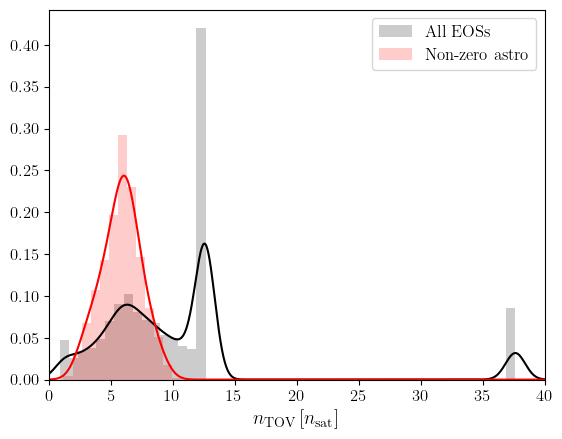

In [5]:
fig, ax = plt.subplots()

x = np.linspace(0, 40, 1000)

ax.hist(
    to_nucleons_per_cubic_femtometre(collated_eos_with_ntov['rhoc(M@Mmax)'])/nsat, 
    bins=50, 
    color='black', 
    alpha=0.2, 
    label='All EOSs',
    density=True
)
ax.hist(
    to_nucleons_per_cubic_femtometre(collated_eos_nonzero_astro['ntov'])/nsat, 
    bins=50, 
    color='red', 
    alpha=0.2, 
    label='Non-zero astro',
    density=True
)

ax.plot(x, ntov_kde(x), c='black')
ax.plot(x, nonzero_astro_ntov_kde(x), c='red')

ax.set_xlabel(r'$n_{\rm TOV}\, [n_{\rm sat}]$')

ax.set_xlim(0, 40)

ax.legend();

In [6]:
ntov_median = np.median(to_nucleons_per_cubic_femtometre(collated_eos_nonzero_astro['ntov']))

In [7]:
e_ntov = np.loadtxt('../data/eos-draws-default/quantities_at_n/energy_density_ntov.dat')
p_ntov = np.loadtxt('../data/eos-draws-default/quantities_at_n/pressure_ntov.dat')

In [8]:
len(e_ntov), len(p_ntov)

(309541, 309541)

In [9]:
len(collated_eos_with_ntov)

309541

In [10]:
collated_eos = pd.read_csv(
    '../data/eos-draws-default/eos-draws-default.csv',
    index_col='eos'
)

In [11]:
e_ntov = e_ntov[collated_eos.logweight_total > -np.inf]
p_ntov = p_ntov[collated_eos.logweight_total > -np.inf]

mask = ~np.logical_or(np.isnan(e_ntov), np.isnan(p_ntov))

e_ntov = e_ntov[mask]
p_ntov = p_ntov[mask]

len(e_ntov), len(p_ntov)

(79600, 79600)

In [12]:
len(collated_eos_nonzero_astro)

79600

In [13]:
sample = rng.choice(len(e_ntov), size=5000, replace=False)

e_ntov = e_ntov[sample]
p_ntov = p_ntov[sample]

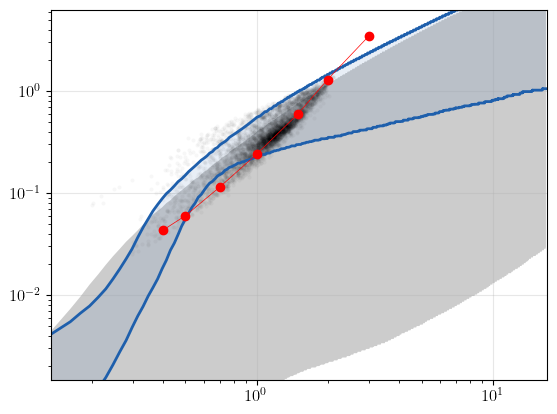

In [14]:
fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

ax.set_xscale('log')
ax.set_yscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

ax.fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=c
)

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

ax.fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
ax.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
ax.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# p vs epsilon at nTOV
# --------------------

ax.plot(
    e_ntov, 
    p_ntov, 
    lw=0, 
    c='k', 
    marker='.', 
    alpha=0.03, 
    markeredgewidth=0,
    zorder=0.9
)

# ---

x_fit = [0.4, 0.5, 0.7, 1, 1.5, 2, 3]
y_fit = [0.043, 0.06, 0.115, 0.24, 0.6, 1.3, 3.5]

ax.plot(x_fit, y_fit, lw=0.5, marker='o', c='r')

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

ax.set_xlim(xlim_pe)
ax.set_ylim(ylim_pe);

In [15]:
x_fit_dense = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense = PchipInterpolator(x_fit, y_fit)(x_fit_dense)

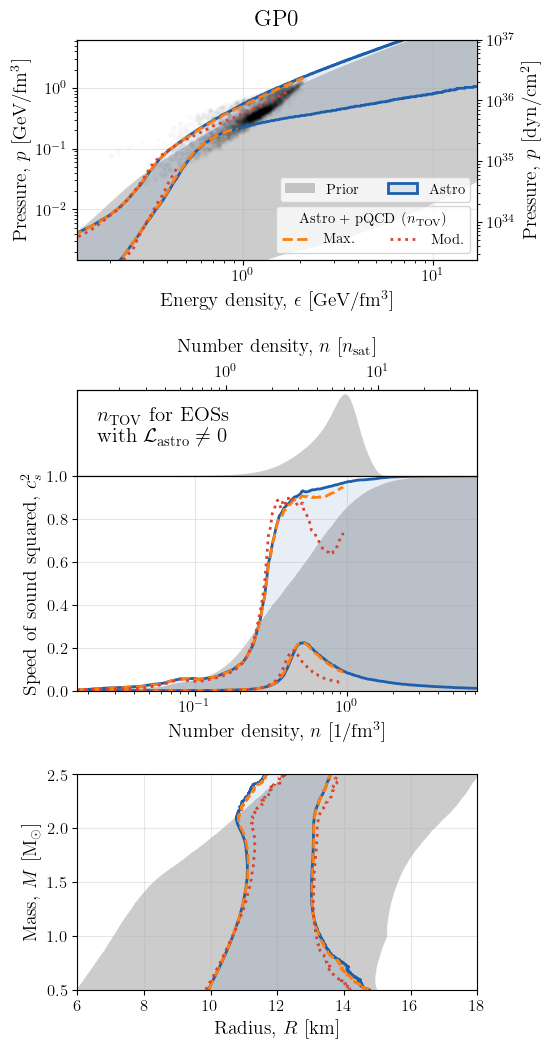

In [17]:
fig_width = 4
fig_height = 10

alpha = 0.17
beta = 0.4
gamma = 0.27

d2 = 0.5*gamma*(beta + 2)
d1 = 0.5*alpha*(d2 + beta + 3)

fig = plt.figure(figsize=(fig_width, fig_height))

main_grid = fig.add_gridspec(
    2, 1, top=0.95, bottom=0, left=0, right=1, hspace=d1, height_ratios=[1, beta+2+d2]
)

ax0 = fig.add_subplot(main_grid[0, 0])

sub_grid = main_grid[1, 0].subgridspec(2, 1, hspace=d2, height_ratios=[1+beta, 1])

ax3 = fig.add_subplot(sub_grid[1, 0])

subsub_grid = sub_grid[0, 0].subgridspec(2, 1, hspace=0, height_ratios=[beta, 1])
ax1 = fig.add_subplot(subsub_grid[0, 0])
ax2 = fig.add_subplot(subsub_grid[1, 0])

ax1.set_xticks([])
ax1.set_yticks([])

for ax in [ax0, ax2, ax3]:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

ax0.set_xscale('log')
ax0.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

ax0.fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_prior.csv'
)

ax2.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_prior.csv'
)

ax3.fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values, 
    astro_quantiles_mr.loc[95,:].values, 
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

ax0.fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
ax0.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
ax0.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro.csv'
)

ax2.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
ax2.plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
ax2.plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro.csv'
)

ax3.fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values,
    astro_quantiles_mr.loc[95,:].values,
    **astro_fill_kwargs
)
ax3.plot(astro_quantiles_mr.loc[5,:].values, y_mr, **astro_line_kwargs)
ax3.plot(astro_quantiles_mr.loc[95,:].values, y_mr, **astro_line_kwargs)

# Astro + pQCD (max, nTOV)
# ------------------------

pqcd_max_kwargs = dict(
    lw=2,
    ls='--',
    zorder=1.1,
    c='#FF7E0D' # #DB422E'
)

invalid_alpha = 0.0

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

ax0.plot(x_pe[:i1], q5[:i1], **pqcd_max_kwargs)
ax0.plot(x_pe[:i2], q95[:i2], **pqcd_max_kwargs)

ax0.plot(x_pe[i1:], q5[i1:], **pqcd_max_kwargs, alpha=invalid_alpha)
ax0.plot(x_pe[i2:], q95[i2:], **pqcd_max_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

ax2.plot(x_cn[mask], q5[mask], **pqcd_max_kwargs)
ax2.plot(x_cn[mask], q95[mask], **pqcd_max_kwargs)

ax2.plot(x_cn[~mask], q5[~mask], **pqcd_max_kwargs, alpha=invalid_alpha)
ax2.plot(x_cn[~mask], q95[~mask], **pqcd_max_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

ax3.plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **pqcd_max_kwargs)
ax3.plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **pqcd_max_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

ax0.plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
ax0.plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

ax0.plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
ax0.plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

ax2.plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
ax2.plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

ax2.plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
ax2.plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

ax3.plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **pqcd_marg_kwargs)
ax3.plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **pqcd_marg_kwargs)

# p vs epsilon at nTOV
# --------------------

ax0.plot(
    e_ntov, 
    p_ntov, 
    lw=0, 
    c='k', 
    marker='.', 
    alpha=0.02, 
    markeredgewidth=0,
    zorder=0.9
)

# ax0.plot(x_fit_dense, y_fit_dense, c='r')

# nTOV posterior
# --------------

# bins = np.logspace(-2, 1, 50)
# ax1.hist(
#     to_nucleons_per_cubic_femtometre(collated_eos_with_ntov['rhoc(M@Mmax)']), 
#     density=True,
#     bins=bins,
#     **prior_kwargs
# )
# ax1.plot(x_cn, nonzero_astro_ntov_kde(x_cn/nsat), **astro_line_kwargs)
ax1.fill_between(x_cn, 0, nonzero_astro_ntov_kde(x_cn/nsat), **prior_kwargs)
ax1.text(
    0.05, 
    0.8, 
    '$n_\\mathrm{TOV}$ for EOSs\nwith $\\mathcal{L}_\\mathrm{astro} \\neq 0$', 
    ha='left',
    va='top',
    transform=ax1.transAxes, 
    fontsize=15
)

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

ax0.set_xlim(xlim_pe)
ax0.set_ylim(ylim_pe)

ax1.set_xlim((x_cn[0],7.20534255445628))
ax1.set_ylim(0)
ax2.set_xlim((x_cn[0],7.20534255445628))
ax2.set_ylim(0, 1)

ax3.set_xlim([6,18])
ax3.set_ylim([y_mr[0], y_mr[-1]])

# ---

twinx = ax0.twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax0.get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = ax1.twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(ax1.get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

ax1.set_xticks([])

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0.23),
)
ax0.add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_max_kwargs),
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = ['Max.', 'Mod.']

l2 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    title_fontsize=10.5,
    title='Astro + pQCD ($n_\mathrm{TOV}$)',
    bbox_to_anchor=(1,0),
    columnspacing=2.4
)
# ax0.add_artist(l2)

# ---

fig.suptitle('GP0')

ax0.set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
ax0.set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

ax2.set_xlabel('Number density, $n$ [1/fm$^3$]')
ax2.set_ylabel('Speed of sound squared, $c_s^2$')

ax3.set_xlabel(r'Radius, $R$ [km]')
ax3.set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp0_posterior.pdf', bbox_inches='tight')

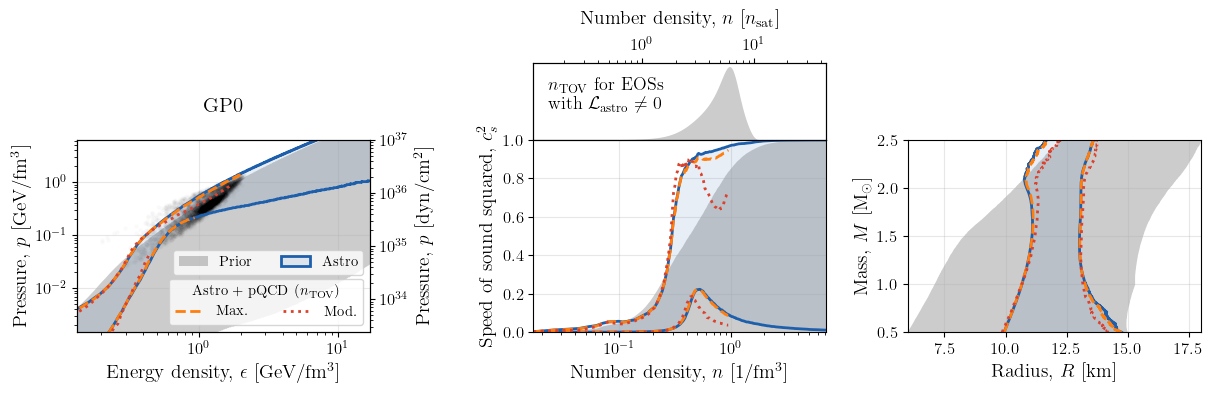

In [114]:
fig, axs = plt.subplots(2, 4, figsize=(14.5, 3.5), height_ratios=[1,2.5], width_ratios=[1,0.001,1,1])
fig.subplots_adjust(hspace=0, wspace=0.37)

axs[0,0].set_visible(False)
axs[0,1].set_visible(False)
axs[1,1].set_visible(False)
axs[0,3].set_visible(False)

axs[0,2].set_xticks([])
axs[0,2].set_yticks([])

axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,2].set_xscale('log')

axs[1,0].set_yscale('log')

for ax in [axs[1,0], axs[1,2], axs[1,3]]:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[1,0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1,2].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_prior.csv'
)

axs[1,3].fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values, 
    astro_quantiles_mr.loc[95,:].values, 
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[1,0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1,0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[1,0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1,2].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1,2].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1,2].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro.csv'
)

axs[1,3].fill_betweenx(
    y_mr, 
    astro_quantiles_mr.loc[5,:].values,
    astro_quantiles_mr.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1,3].plot(astro_quantiles_mr.loc[5,:].values, y_mr, **astro_line_kwargs)
axs[1,3].plot(astro_quantiles_mr.loc[95,:].values, y_mr, **astro_line_kwargs)

# Astro + pQCD (max, nTOV)
# ------------------------

pqcd_max_kwargs = dict(
    lw=2,
    ls='--',
    zorder=1.1,
    c='#FF7E0D' # #DB422E'
)

invalid_alpha = 0.0

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[1,0].plot(x_pe[:i1], q5[:i1], **pqcd_max_kwargs)
axs[1,0].plot(x_pe[:i2], q95[:i2], **pqcd_max_kwargs)

axs[1,0].plot(x_pe[i1:], q5[i1:], **pqcd_max_kwargs, alpha=invalid_alpha)
axs[1,0].plot(x_pe[i2:], q95[i2:], **pqcd_max_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1,2].plot(x_cn[mask], q5[mask], **pqcd_max_kwargs)
axs[1,2].plot(x_cn[mask], q95[mask], **pqcd_max_kwargs)

axs[1,2].plot(x_cn[~mask], q5[~mask], **pqcd_max_kwargs, alpha=invalid_alpha)
axs[1,2].plot(x_cn[~mask], q95[~mask], **pqcd_max_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_Xmarg_mu2.6.csv'
)

axs[1,3].plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **pqcd_max_kwargs)
axs[1,3].plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **pqcd_max_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[1,0].plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
axs[1,0].plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

axs[1,0].plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[1,0].plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1,2].plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
axs[1,2].plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

axs[1,2].plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[1,2].plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[1,3].plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **pqcd_marg_kwargs)
axs[1,3].plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **pqcd_marg_kwargs)

# p vs epsilon at nTOV
# --------------------

axs[1,0].plot(
    e_ntov, 
    p_ntov, 
    lw=0, 
    c='k', 
    marker='.', 
    alpha=0.02, 
    markeredgewidth=0,
    zorder=0.9
)

# nTOV posterior
# --------------

axs[0,2].fill_between(x_cn, 0, nonzero_astro_ntov_kde(x_cn/nsat), **prior_kwargs)
axs[0,2].text(
    0.05, 
    0.8, 
    '$n_\\mathrm{TOV}$ for EOSs\nwith $\\mathcal{L}_\\mathrm{astro} \\neq 0$', 
    ha='left',
    va='top',
    transform=axs[0,2].transAxes, 
    fontsize=13
)

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[1,0].set_xlim(xlim_pe)
axs[1,0].set_ylim(ylim_pe)

axs[0,2].set_xlim((x_cn[0],7.20534255445628))
axs[0,2].set_ylim(0)
axs[1,2].set_xlim((x_cn[0],7.20534255445628))
axs[1,2].set_ylim(0, 1)

axs[1,3].set_xlim([6,18])
axs[1,3].set_ylim([y_mr[0], y_mr[-1]])

# ---

twinx = axs[1,0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1,0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[0,2].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[0,2].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = axs[1,0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0.26),
)
axs[1,0].add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_max_kwargs),
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = ['Max.', 'Mod.']

l2 = axs[1,0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    title_fontsize=10.5,
    title='Astro + pQCD ($n_\mathrm{TOV}$)',
    bbox_to_anchor=(1,0),
    columnspacing=2.4
)

# ---

axs[1,0].text(
    0.5, 
    1.22, 
    'GP0', 
    ha='center',
    va='top',
    transform=axs[1,0].transAxes, 
    fontsize=15
)

# ---

axs[1,0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[1,0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1,2].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1,2].set_ylabel('Speed of sound squared, $c_s^2$')

axs[1,3].set_xlabel(r'Radius, $R$ [km]')
axs[1,3].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp0_posterior_alt.pdf', bbox_inches='tight')

In [31]:
astro_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro.csv'
)

q5 = astro_quantiles_mr.loc[5,:].values
q95 = astro_quantiles_mr.loc[95,:].values

In [32]:
index = np.argmin(np.abs(y_mr - 1.4))

In [33]:
q5[index], q95[index]

(11.036640452226791, 13.024830443420784)

In [34]:
from pqcd.utils import weighted_quantile

In [54]:
weights = np.exp(collated_eos['logweight_total'].values - max(collated_eos['logweight_total'].values))

In [55]:
l, m, h = weighted_quantile(collated_eos_with_ntov['R(M=1.4)'].values, quantiles=[0.05, 0.5, 0.95], weights=weights)
print(f'{m:.2f}+{h-m:.2f}-{m-l:.2f}')

12.06+0.97-1.02


In [43]:
old_weights = np.exp(collated_eos_with_ntov['logweight_total'].values - max(collated_eos_with_ntov['logweight_total'].values))

In [53]:
l, m, h = weighted_quantile(collated_eos_with_ntov['R(M=1.4)'].values, quantiles=[0.05, 0.5, 0.95], weights=old_weights)
print(f'{m:.2f}+{h-m:.2f}-{m-l:.2f}')

12.56+0.90-1.20


In [57]:
astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro.csv')
)

astro_q5 = astro_quantiles_pe.loc[5,:].values
astro_q95 = astro_quantiles_pe.loc[95,:].values

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

In [59]:
index = np.argmin(np.abs(x_pe - 1))

In [60]:
100*(astro_q95[index] - q95[index])/astro_q95[index]

29.90429908601281

### GP1

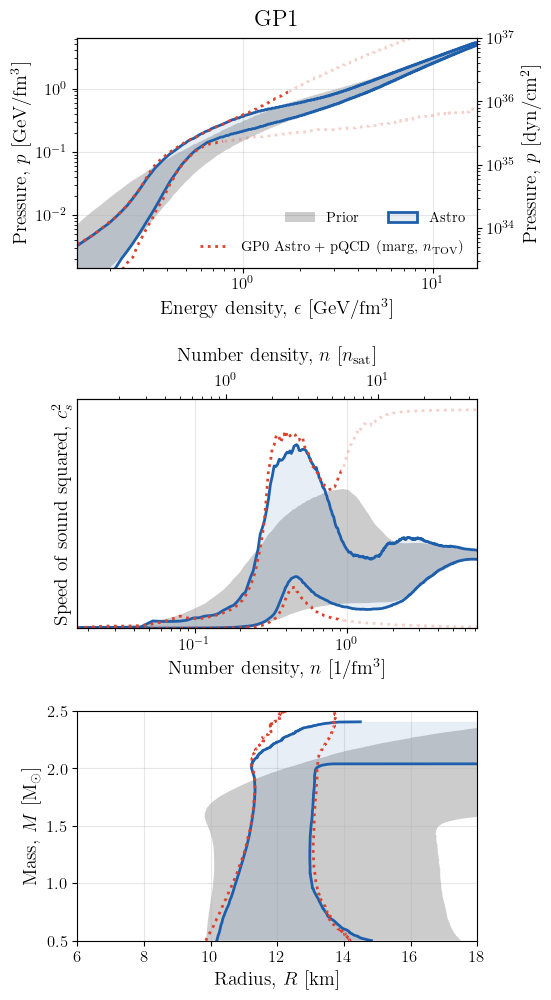

In [16]:
fig_width = 4
fig_height = 9.5

d1 = 0.34
d2 = 0.36

fig = plt.figure(figsize=(fig_width, fig_height))

main_grid = fig.add_gridspec(
    2, 1, top=0.95, bottom=0, left=0, right=1, hspace=d1, height_ratios=[1, 2+d2]
)

ax0 = fig.add_subplot(main_grid[0, 0])

sub_grid = main_grid[1, 0].subgridspec(2, 1, hspace=d2, height_ratios=[1, 1])

ax1 = fig.add_subplot(sub_grid[0, 0])
ax2 = fig.add_subplot(sub_grid[1, 0])

ax1.set_xticks([])
ax1.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

ax0.set_xscale('log')
ax0.set_yscale('log')
ax1.set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

# ---

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

ax0.fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

ax1.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_prior.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax2.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

# ---

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

ax0.fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
ax0.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
ax0.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

ax1.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
ax1.plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
ax1.plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# --- 

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_astro.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax2.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    **astro_fill_kwargs
)

ax2.plot(astro_quantiles_mr[0], y_mr, **astro_line_kwargs)
ax2.plot(astro_quantiles_mr[2], y_mr, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

invalid_alpha = 0.25

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

ax0.plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
ax0.plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

ax0.plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
ax0.plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

ax1.plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
ax1.plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

ax1.plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
ax1.plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

ax2.plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **pqcd_marg_kwargs)
ax2.plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **pqcd_marg_kwargs)

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

ax0.set_xlim(xlim_pe)
ax0.set_ylim(ylim_pe)

ax1.set_xlim((x_cn[0],7.20534255445628))
ax1.set_ylim(0)

ax2.set_xlim([6,18])
ax2.set_ylim([y_mr[0], y_mr[-1]])

# ---

twinx = ax0.twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax0.get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = ax1.twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(ax1.get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0.13),
    frameon=False
)
ax0.add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = ['GP0 Astro + pQCD (marg, $n_\mathrm{TOV}$)']

l2 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0),
    frameon=False
)
# ax0.add_artist(l2)

# ---

fig.suptitle('GP1')

ax0.set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
ax0.set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

ax1.set_xlabel('Number density, $n$ [1/fm$^3$]')
ax1.set_ylabel('Speed of sound squared, $c_s^2$')

ax2.set_xlabel(r'Radius, $R$ [km]')
ax2.set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp1_posterior_with_m_r.pdf', bbox_inches='tight')

Text(0, 0.5, 'Speed of sound squared, $c_s^2$')

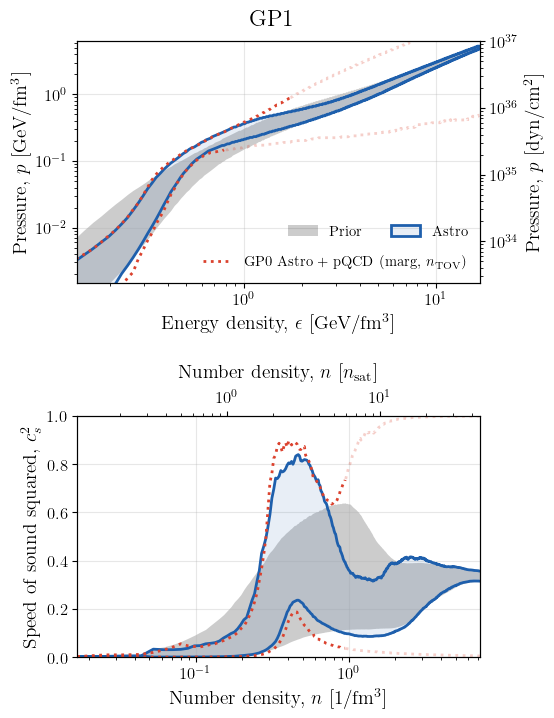

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(5.2, 8))
fig.subplots_adjust(hspace=0.55)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

# ---

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

# ---

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

invalid_alpha = 0.25

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[0].plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
axs[0].plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

axs[0].plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[0].plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1].plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
axs[1].plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

axs[1].plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[1].plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0,1)

# ---

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0.13),
    frameon=False
)
axs[0].add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = ['GP0 Astro + pQCD (marg, $n_\mathrm{TOV}$)']

l2 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0),
    frameon=False
)

# ---

fig.suptitle('GP1', y=0.92)

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2$')

fig.savefig('figures/paper/astro_pqcd_gp1_posterior.pdf', bbox_inches='tight');

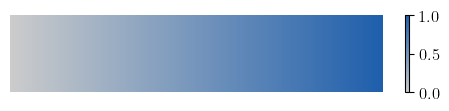

In [16]:
colors = ["#cccccc", cm.roma(0.9)]

gpn_cmap = LinearSegmentedColormap.from_list("gray_to_blue", colors)

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(6, 1))
plt.imshow(gradient, aspect="auto", cmap=gpn_cmap)
plt.colorbar()
plt.axis("off")
plt.show()

In [17]:
def rescale(weight, vmin=1e-5):
    if weight < vmin:
        return 0
    else:
        log_weight = np.log10(weight)
        return (log_weight-np.log10(vmin))/(0-np.log10(vmin))

In [18]:
eos_dir = '../data/eos-draws-modified/gp1'

collated_eos_gp1 = pd.read_csv(f'{eos_dir}/eos-draws-modified-gp1.csv')

gp1_astro_weights = np.exp(
    collated_eos_gp1.logweight_total - collated_eos_gp1.logweight_total.max()
).values

gp1_astro_weights /= max(gp1_astro_weights)

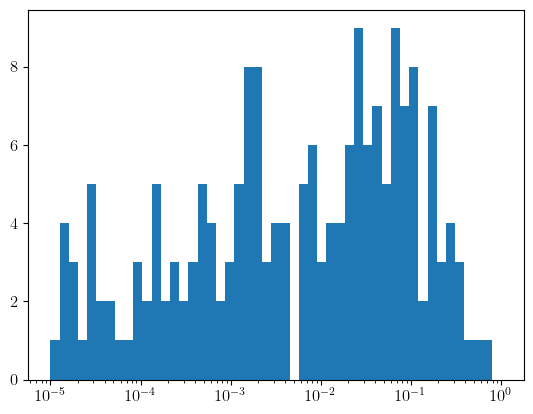

In [19]:
l = 25000
number = 1000

fig, ax = plt.subplots()
bins = np.logspace(-5, 0, 50)
ax.hist(gp1_astro_weights[l:l+number], bins=bins)
ax.set_xscale('log')

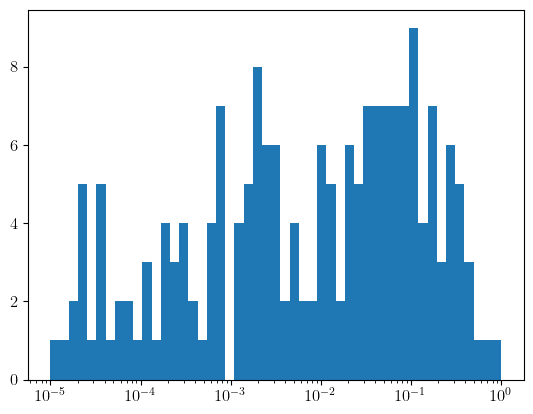

In [20]:
gp1_astro_weights_sample = gp1_astro_weights[l:l+number]
gp1_astro_weights_sample /= max(gp1_astro_weights_sample)

fig, ax = plt.subplots()
bins = np.logspace(-5, 0, 50)
ax.hist(gp1_astro_weights_sample, bins=bins)
ax.set_xscale('log')

Text(0, 0.5, 'Speed of sound squared, $c_s^2$')

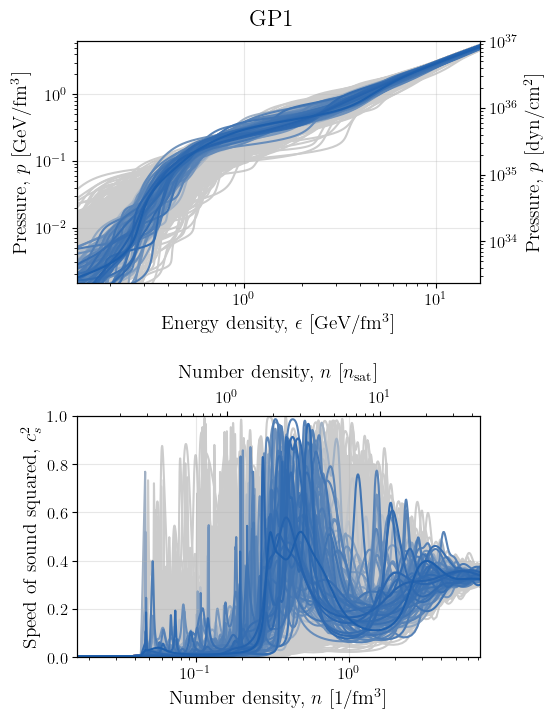

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(5.2, 8))
fig.subplots_adjust(hspace=0.55)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# ---

for i, n in enumerate(collated_eos_gp1.eos.iloc[l:l+number]):

    df = pd.read_csv(
        f'../data/eos-draws-modified/gp1/margagn/DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    weight = rescale(gp1_astro_weights_sample[i], vmin=1e-3)

    axs[0].plot(
        energy_density,
        pressure,
        c=gpn_cmap(weight),
        zorder=weight
    )

    axs[1].plot(
        number_density,
        speed_of_sound_squared,
        c=gpn_cmap(weight),
        zorder=weight
    )

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0,1)

# ---

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---



# ---

fig.suptitle('GP1', y=0.92)

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2$')

# fig.savefig('figures/paper/astro_pqcd_gp1_posterior_alt.pdf', bbox_inches='tight')

In [21]:
e_10nsat = np.loadtxt('../data/eos-draws-default/quantities_at_n/energy_density_10nsat.dat')
p_10nsat = np.loadtxt('../data/eos-draws-default/quantities_at_n/pressure_10nsat.dat')

mask = ~np.logical_or(np.isnan(e_10nsat), np.isnan(p_10nsat))
e_10nsat = e_10nsat[mask]
p_10nsat = p_10nsat[mask]

sample = rng.choice(len(e_10nsat), size=10000, replace=False)
e_10nsat = e_10nsat[sample]
p_10nsat = p_10nsat[sample]

x_fit = [1.45, 1.51, 1.53, 1.56, 1.64, 1.81, 2.0, 2.5, 2.9, 3.8, 5.9]
y_fit = [ylim_pe[0], 3e-3, 2e-2, 1e-1, 2.5e-1, 5e-1, 8e-1, 1.5, 2, 3, 5]

x_fit_dense_10nsat = np.linspace(x_fit[0], x_fit[-1], 1000)
y_fit_dense_10nsat = PchipInterpolator(x_fit, y_fit)(x_fit_dense_10nsat)

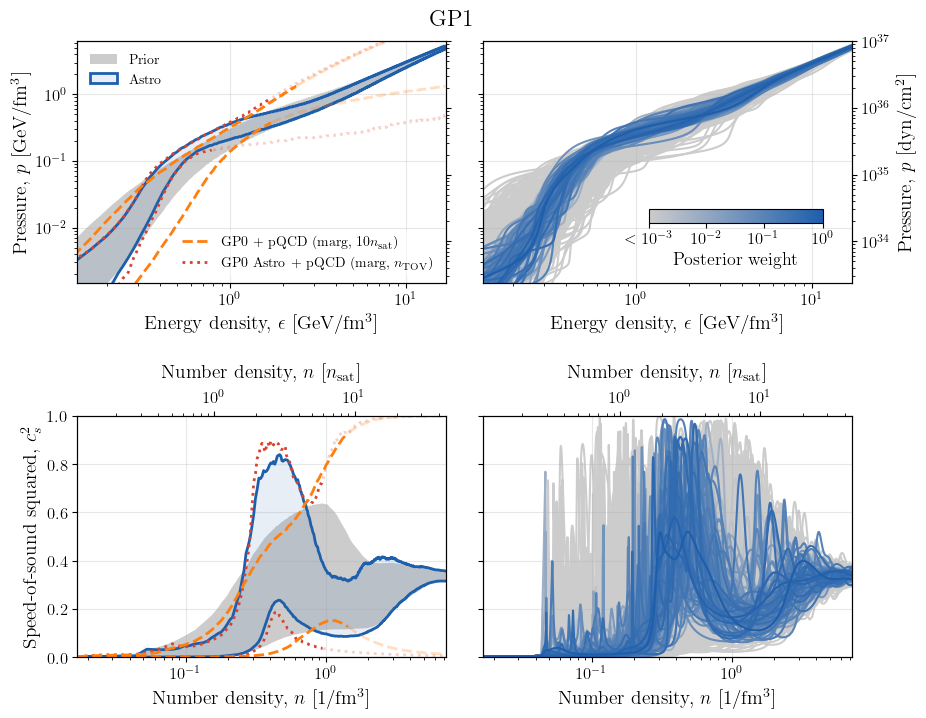

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) # , layout='constrained')
fig.subplots_adjust(hspace=0.55, wspace=0.1)

for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)


axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[1][1].set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)
y_fit_interp_10nsat = np.interp(x_pe, x_fit_dense_10nsat, y_fit_dense_10nsat, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

# ---

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0][0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

# ---

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0][0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

pqcd_kwargs = dict(
    lw=2,
    ls='--',
    zorder=1.1,
    c='C1'
)

invalid_alpha = 0.25

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp_10nsat)**2)
i2 = np.argmin((q95 - y_fit_interp_10nsat)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **pqcd_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **pqcd_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **pqcd_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **pqcd_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1][0].plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_pqcd_10nsat_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < 9*nsat

axs[1][0].plot(x_cn[mask], q5[mask], **pqcd_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **pqcd_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **pqcd_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **pqcd_kwargs, alpha=invalid_alpha)

# ---

for i, n in enumerate(collated_eos_gp1.eos.iloc[l:l+number]):

    df = pd.read_csv(
        f'../data/eos-draws-modified/gp1/margagn/DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    weight = rescale(gp1_astro_weights_sample[i], vmin=1e-3)

    axs[0][1].plot(
        energy_density,
        pressure,
        c=gpn_cmap(weight),
        zorder=weight
    )

    axs[1][1].plot(
        number_density,
        speed_of_sound_squared,
        c=gpn_cmap(weight),
        zorder=weight
    )

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0][0].set_xlim(xlim_pe)
axs[0][0].set_ylim(ylim_pe)

axs[1][0].set_xlim((x_cn[0],7.20534255445628))
axs[1][0].set_ylim(0,1)

axs[0][1].set_xlim(xlim_pe)
axs[0][1].set_ylim(ylim_pe)

axs[1][1].set_xlim((x_cn[0],7.20534255445628))
axs[1][1].set_ylim(0,1)

# ---

twinx = axs[0][0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][0].get_ylim())))
twinx.set_yticklabels([])

twinx = axs[0][1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1][0].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][0].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

twiny = axs[1][1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

axs[0][1].set_yticklabels([])
axs[1][1].set_yticklabels([])

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='upper left', 
    ncol=1,
    fontsize=10, 
    # bbox_to_anchor=(1,0.23),
)
l1.get_frame().set_alpha(None)
l1.get_frame().set_edgecolor((0, 0, 0, 0.))
l1.get_frame().set_facecolor((1, 1, 1, 0.5))
axs[0][0].add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_kwargs),
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = [
    'GP0 + pQCD (marg, $10n_\mathrm{sat}$)',
    'GP0 Astro + pQCD (marg, $n_\mathrm{TOV}$)'
]

l2 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=1,
    fontsize=10, 
    bbox_to_anchor=(1,0),
    # frameon=False
)
l2.get_frame().set_alpha(None)
l2.get_frame().set_edgecolor((0, 0, 0, 0.))
l2.get_frame().set_facecolor((1, 1, 1, 0.5))

# ---

cbaxes = axs[0][1].inset_axes(
    [0.45, 0.25, 0.47, 0.055]
   # loc='lower right',
    # bbox_to_anchor=(0,0.21,0.95,1),
    # bbox_transform=axs[0][1].transAxes
    ) 
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(cmap=gpn_cmap),
    cax=cbaxes, 
    ticks=[0, 0.33, 0.66, 1],
    orientation='horizontal',
    )
cbar1.set_ticklabels(['$< 10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
cbar1.set_label('Posterior weight', size=13)

# ---

fig.suptitle('GP1', y=0.92)

axs[0][0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0][0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1][0].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1][0].set_ylabel('Speed-of-sound squared, $c_s^2$')

axs[1][1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[0][1].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')

fig.savefig('figures/paper/astro_pqcd_gp1_posterior_alt.pdf', bbox_inches='tight')

### GP2

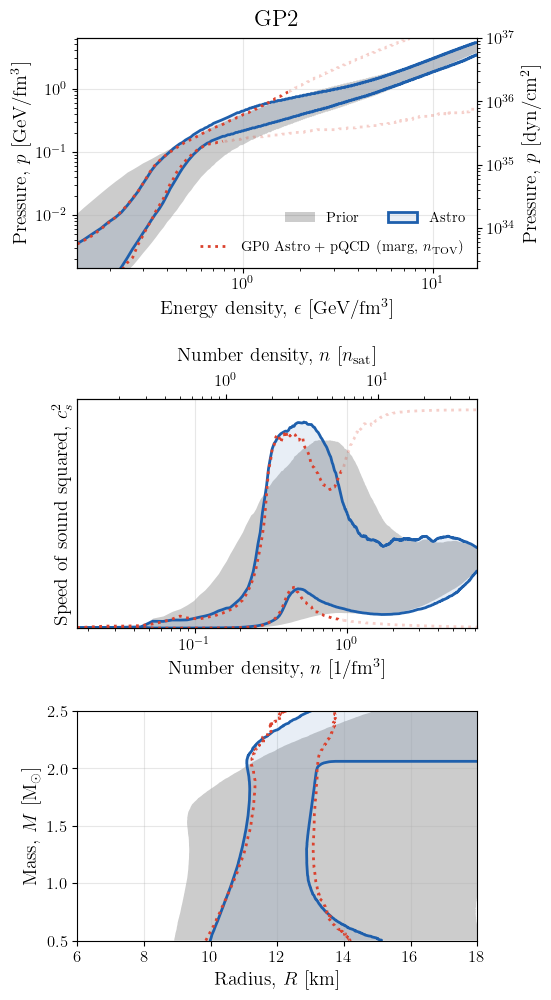

In [ ]:
fig_width = 4
fig_height = 9.5

d1 = 0.34
d2 = 0.36

fig = plt.figure(figsize=(fig_width, fig_height))

main_grid = fig.add_gridspec(
    2, 1, top=0.95, bottom=0, left=0, right=1, hspace=d1, height_ratios=[1, 2+d2]
)

ax0 = fig.add_subplot(main_grid[0, 0])

sub_grid = main_grid[1, 0].subgridspec(2, 1, hspace=d2, height_ratios=[1, 1])

ax1 = fig.add_subplot(sub_grid[0, 0])
ax2 = fig.add_subplot(sub_grid[1, 0])

ax1.set_xticks([])
ax1.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

ax0.set_xscale('log')
ax0.set_yscale('log')
ax1.set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

# ---

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_prior.csv')
)

ax0.fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_prior.csv'
)

ax1.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantiles/r_of_m_quantiles_prior.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax2.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

# ---

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_astro.csv')
)

ax0.fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
ax0.plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
ax0.plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_astro.csv'
)

ax1.fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
ax1.plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
ax1.plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# --- 

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantiles/r_of_m_quantiles_astro.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax2.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    **astro_fill_kwargs
)

ax2.plot(astro_quantiles_mr[0], y_mr, **astro_line_kwargs)
ax2.plot(astro_quantiles_mr[2], y_mr, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

invalid_alpha = 0.25

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

ax0.plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
ax0.plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

ax0.plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
ax0.plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

ax1.plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
ax1.plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

ax1.plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
ax1.plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

ax2.plot(pqcd_quantiles_mr.loc[5,:].values, y_mr, **pqcd_marg_kwargs)
ax2.plot(pqcd_quantiles_mr.loc[95,:].values, y_mr, **pqcd_marg_kwargs)

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

ax0.set_xlim(xlim_pe)
ax0.set_ylim(ylim_pe)

ax1.set_xlim((x_cn[0],7.20534255445628))
ax1.set_ylim(0)

ax2.set_xlim([6,18])
ax2.set_ylim([y_mr[0], y_mr[-1]])

# ---

twinx = ax0.twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax0.get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = ax1.twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(ax1.get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0.13),
    frameon=False
)
ax0.add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = ['GP0 Astro + pQCD (marg, $n_\mathrm{TOV}$)']

l2 = ax0.legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0),
    frameon=False
)
# ax0.add_artist(l2)

# ---

fig.suptitle('GP2')

ax0.set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
ax0.set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

ax1.set_xlabel('Number density, $n$ [1/fm$^3$]')
ax1.set_ylabel('Speed of sound squared, $c_s^2$')

ax2.set_xlabel(r'Radius, $R$ [km]')
ax2.set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp2_posterior.pdf', bbox_inches='tight')

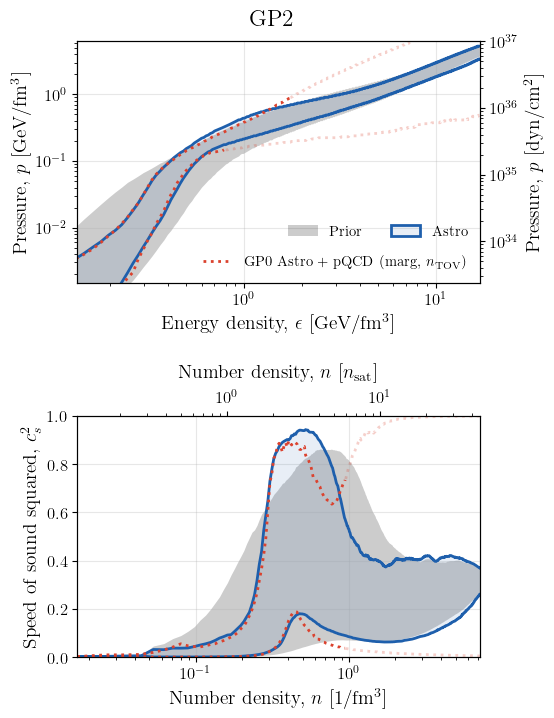

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(5.2, 8))
fig.subplots_adjust(hspace=0.55)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

# ---

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

# ---

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

invalid_alpha = 0.25

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[0].plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
axs[0].plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

axs[0].plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[0].plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1].plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
axs[1].plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

axs[1].plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[1].plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0,1)

# ---

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0.13),
    frameon=False
)
axs[0].add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = ['GP0 Astro + pQCD (marg, $n_\mathrm{TOV}$)']

l2 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=2,
    fontsize=10.5, 
    bbox_to_anchor=(1,0),
    frameon=False
)

# ---

fig.suptitle('GP2', y=0.92)

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2$')

fig.savefig('figures/paper/astro_pqcd_gp2_posterior_alt.pdf', bbox_inches='tight')

In [33]:
eos_dir = '../data/eos-draws-modified/gp2'

collated_eos_gp2 = pd.read_csv(f'{eos_dir}/eos-draws-modified-gp2.csv')

gp2_astro_weights = np.exp(
    collated_eos_gp2.logweight_total - collated_eos_gp2.logweight_total.max()
).values

gp2_astro_weights /= max(gp2_astro_weights)

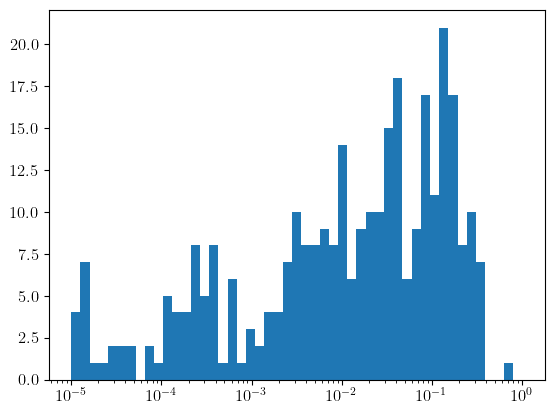

In [34]:
l = 10000
number = 1000

fig, ax = plt.subplots()
bins = np.logspace(-5, 0, 50)
ax.hist(gp2_astro_weights[l:l+number], bins=bins)
ax.set_xscale('log')

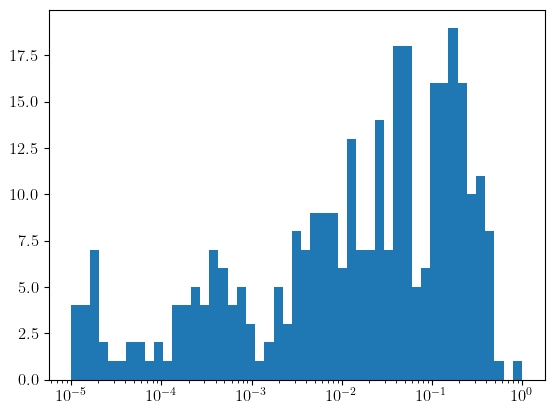

In [35]:
gp2_astro_weights_sample = gp2_astro_weights[l:l+number]
gp2_astro_weights_sample /= max(gp2_astro_weights_sample)

fig, ax = plt.subplots()
bins = np.logspace(-5, 0, 50)
ax.hist(gp2_astro_weights_sample, bins=bins)
ax.set_xscale('log')

Text(0, 0.5, 'Speed of sound squared, $c_s^2$')

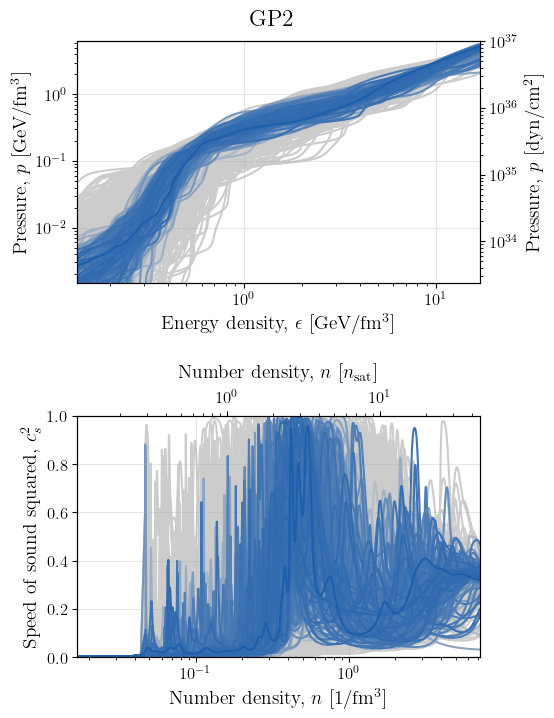

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(5.2, 8))
fig.subplots_adjust(hspace=0.55)

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# ---

for i, n in enumerate(collated_eos_gp2.eos.iloc[l:l+number]):

    df = pd.read_csv(
        f'../data/eos-draws-modified/gp2/margagn/DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    weight = rescale(gp2_astro_weights_sample[i], vmin=1e-3)

    axs[0].plot(
        energy_density,
        pressure,
        c=gpn_cmap(weight),
        zorder=weight
    )

    axs[1].plot(
        number_density,
        speed_of_sound_squared,
        c=gpn_cmap(weight),
        zorder=weight
    )

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0,1)

# ---

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---



# ---

fig.suptitle('GP2', y=0.92)

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2$')

# fig.savefig('figures/paper/astro_pqcd_gp1_posterior_alt.pdf', bbox_inches='tight')

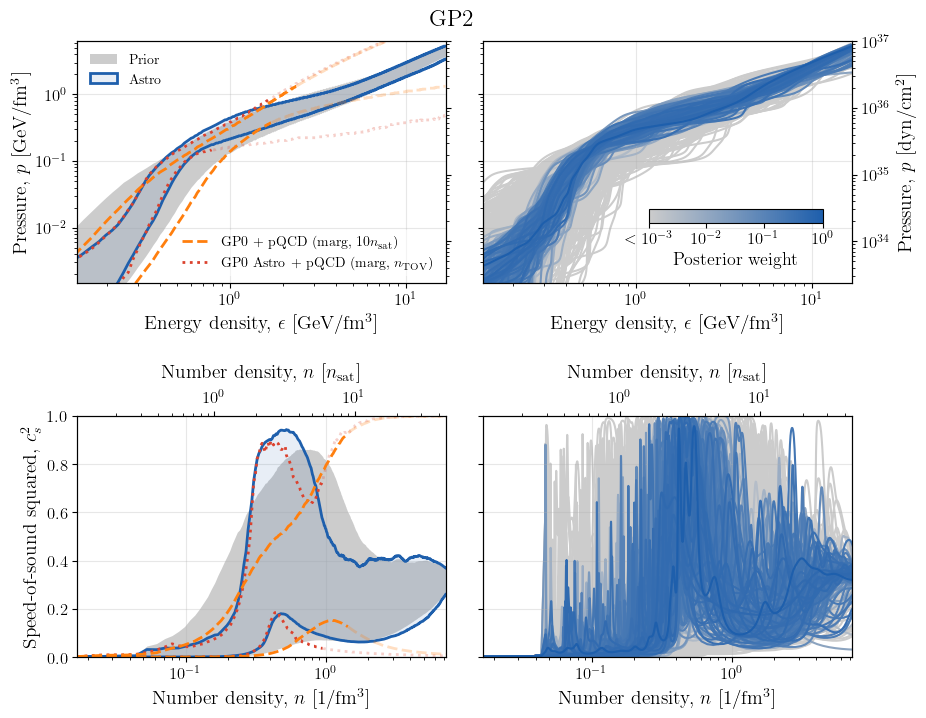

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) # , layout='constrained')
fig.subplots_adjust(hspace=0.55, wspace=0.1)

for ax in axs.flatten():
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)


axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
axs[1][0].set_xscale('log')

axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')
axs[1][1].set_xscale('log')

# ---

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

y_fit_interp = np.interp(x_pe, x_fit_dense, y_fit_dense, left=-100)

# Prior
# -----

prior_kwargs = dict(
    lw=0,
    alpha=0.2,
    zorder=0.1,
    color='k'
)

# ---

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0][0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    **prior_kwargs
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **prior_kwargs
)

# Astro-only
# ----------

astro_c = cm.roma(0.9)

astro_fill_kwargs = dict(
    lw=0,
    zorder=0.9,
    facecolor=list(astro_c)[:3] + [0.1]
)

astro_line_kwargs = dict(
    lw=2,
    zorder=1,
    c=astro_c
)

# ---

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0][0].fill_between(
    x_pe,
    astro_quantiles_pe.loc[5,:].values,
    astro_quantiles_pe.loc[95,:].values,
    **astro_fill_kwargs
)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[5,:].values, **astro_line_kwargs)
axs[0][0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, **astro_line_kwargs)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1][0].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    **astro_fill_kwargs
)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[5,:].values, **astro_line_kwargs)
axs[1][0].plot(x_cn, astro_quantiles_cn.loc[95,:].values, **astro_line_kwargs)

# Astro + pQCD (marg, nTOV)
# -------------------------

pqcd_marg_kwargs = dict(
    lw=2,
    ls=':',
    zorder=1.1,
    c='#DB422E'
)

invalid_alpha = 0.25

# ---

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp)**2)
i2 = np.argmin((q95 - y_fit_interp)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **pqcd_marg_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **pqcd_marg_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **pqcd_marg_kwargs, alpha=invalid_alpha)

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv(f'../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

q5 = pqcd_quantiles_pe.loc[5,:].values
q95 = pqcd_quantiles_pe.loc[95,:].values

i1 = np.argmin((q5 - y_fit_interp_10nsat)**2)
i2 = np.argmin((q95 - y_fit_interp_10nsat)**2)

axs[0][0].plot(x_pe[:i1], q5[:i1], **pqcd_kwargs)
axs[0][0].plot(x_pe[:i2], q95[:i2], **pqcd_kwargs)

axs[0][0].plot(x_pe[i1:], q5[i1:], **pqcd_kwargs, alpha=invalid_alpha)
axs[0][0].plot(x_pe[i2:], q95[i2:], **pqcd_kwargs, alpha=invalid_alpha)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < ntov_median

axs[1][0].plot(x_cn[mask], q5[mask], **pqcd_marg_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **pqcd_marg_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **pqcd_marg_kwargs, alpha=invalid_alpha)

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_pqcd_10nsat_marg.csv'
)

q5 = pqcd_quantiles_cn.loc[5,:].values
q95 = pqcd_quantiles_cn.loc[95,:].values

mask = x_cn < 9*nsat

axs[1][0].plot(x_cn[mask], q5[mask], **pqcd_kwargs)
axs[1][0].plot(x_cn[mask], q95[mask], **pqcd_kwargs)

axs[1][0].plot(x_cn[~mask], q5[~mask], **pqcd_kwargs, alpha=invalid_alpha)
axs[1][0].plot(x_cn[~mask], q95[~mask], **pqcd_kwargs, alpha=invalid_alpha)

# ---

for i, n in enumerate(collated_eos_gp2.eos.iloc[l:l+number]):

    df = pd.read_csv(
        f'../data/eos-draws-modified/gp2/margagn/DRAWmod1000-{int(n)//1000:06}/eos-draw-{int(n):06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    weight = rescale(gp2_astro_weights_sample[i], vmin=1e-3)

    axs[0][1].plot(
        energy_density,
        pressure,
        c=gpn_cmap(weight),
        zorder=weight
    )

    axs[1][1].plot(
        number_density,
        speed_of_sound_squared,
        c=gpn_cmap(weight),
        zorder=weight
    )

# ---

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

axs[0][0].set_xlim(xlim_pe)
axs[0][0].set_ylim(ylim_pe)

axs[1][0].set_xlim((x_cn[0],7.20534255445628))
axs[1][0].set_ylim(0,1)

axs[0][1].set_xlim(xlim_pe)
axs[0][1].set_ylim(ylim_pe)

axs[1][1].set_xlim((x_cn[0],7.20534255445628))
axs[1][1].set_ylim(0,1)

# ---

twinx = axs[0][0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][0].get_ylim())))
twinx.set_yticklabels([])

twinx = axs[0][1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0][1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1][0].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][0].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

twiny = axs[1][1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1][1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

axs[0][1].set_yticklabels([])
axs[1][1].set_yticklabels([])

# ---

custom_handles = [
    mpatches.Patch(**prior_kwargs),
    mpatches.Patch(
        facecolor=list(astro_c)[:3] + [0.1],
        edgecolor=astro_c,
        lw=2
    )
]
custom_labels = ['Prior', 'Astro']

l1 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='upper left', 
    ncol=1,
    fontsize=10, 
    # bbox_to_anchor=(1,0.23),
)
l1.get_frame().set_alpha(None)
l1.get_frame().set_edgecolor((0, 0, 0, 0.))
l1.get_frame().set_facecolor((1, 1, 1, 0.5))
axs[0][0].add_artist(l1)

custom_handles = [
    plt.Line2D([0], [0], **pqcd_kwargs),
    plt.Line2D([0], [0], **pqcd_marg_kwargs),
]
custom_labels = [
    'GP0 + pQCD (marg, $10n_\mathrm{sat}$)',
    'GP0 Astro + pQCD (marg, $n_\mathrm{TOV}$)'
]

l2 = axs[0][0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    ncol=1,
    fontsize=10, 
    bbox_to_anchor=(1,0),
    # frameon=False
)
l2.get_frame().set_alpha(None)
l2.get_frame().set_edgecolor((0, 0, 0, 0.))
l2.get_frame().set_facecolor((1, 1, 1, 0.5))

# ---

cbaxes = axs[0][1].inset_axes(
    [0.45, 0.25, 0.47, 0.055]
   # loc='lower right',
    # bbox_to_anchor=(0,0.21,0.95,1),
    # bbox_transform=axs[0][1].transAxes
    ) 
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(cmap=gpn_cmap),
    cax=cbaxes, 
    ticks=[0, 0.33, 0.66, 1],
    orientation='horizontal',
    )
cbar1.set_ticklabels(['$< 10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])
cbar1.set_label('Posterior weight', size=13)

# ---

fig.suptitle('GP2', y=0.92)

axs[0][0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0][0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1][0].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1][0].set_ylabel('Speed-of-sound squared, $c_s^2$')

axs[1][1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[0][1].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')

fig.savefig('figures/paper/astro_pqcd_gp2_posterior_alt.pdf', bbox_inches='tight')

### Comparisons

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 11), layout='constrained')

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# GP0 marg pQCD, 10nsat
# ---------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_pqcd_10nsat_marg.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with pQCD (marg, $10n_\mathrm{sat}$)'
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_pqcd_10nsat_marg.csv'
)

axs[1].plot(
    to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000)), 
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with pQCD (marg, $10n_\mathrm{sat}$)'
)
axs[1].plot(
    to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 2.8e15, 1000)), 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_pqcd_10nsat_marg.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with pQCD (marg, $10n_\mathrm{sat}$)'
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw
)

# GP1 prior
# ---------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='GP1 prior',
    zorder=0.1
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='k',
    alpha=0.2,
    linewidth=0,
    label='GP1 prior',
    zorder=0.1
)

# ---

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_prior.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    color='k',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# GP2 prior
# ---------

prior_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_prior.csv')
)

axs[0].fill_between(
    x_pe,
    prior_quantiles_pe.loc[5,:].values,
    prior_quantiles_pe.loc[95,:].values,
    color='C0',
    alpha=0.2,
    linewidth=0,
    label='GP2 prior',
    zorder=0.1
)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_prior.csv'
)

axs[1].fill_between(
    x_cn,
    astro_quantiles_cn.loc[5,:].values,
    astro_quantiles_cn.loc[95,:].values,
    color='C0',
    alpha=0.2,
    linewidth=0,
    label='GP2 prior',
    zorder=0.1
)

# ---

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantiles/r_of_m_quantiles_prior.dat'
)
astro_quantiles_mr[2][np.isnan(astro_quantiles_mr[2])] = 100

ax.fill_betweenx(
    y_mr, 
    astro_quantiles_mr[0], 
    astro_quantiles_mr[2], 
    color='C0',
    alpha=0.2,
    linewidth=0,
    label='Prior',
    zorder=0.1
)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

# axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
# axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

# axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0, 1)

axs[2].set_xlim([6,18])
axs[2].set_ylim([y_mr[0], y_mr[-1]])

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$')

axs[2].set_xlabel(r'Radius, $R$ [km]')
axs[2].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/pqcd_gp0_gp1_gp2_comparison.pdf', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6, 11), layout='constrained')

for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

x_pe = to_GeV_per_cubic_femtometre(np.linspace(5e13, 3e16, 1000))
x_cn = to_nucleons_per_cubic_femtometre(np.linspace(2.8e13, 1.5e16, 1000))
y_mr = np.linspace(0.5, 2.5, 1000)

# GP0 astro + marg pQCD, nTOV
# ---------------------------

pqcd_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-default/quantiles/p_of_eps_quantiles_astro_pqcd_ntov_marg.csv')
)

axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[0].plot(
    x_pe, 
    pqcd_quantiles_pe.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_cn = pd.read_csv(
    '../data/eos-draws-default/quantiles/cs2_of_rho_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[1].plot(
    x_cn,
    pqcd_quantiles_cn.loc[5,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[1].plot(
    x_cn, 
    pqcd_quantiles_cn.loc[95,:].values, 
    color='C3', 
    linestyle='-',
    lw=lw
)

# ---

pqcd_quantiles_mr = pd.read_csv(
    '../data/eos-draws-default/quantiles/r_of_m_quantiles_astro_pqcd_ntov_marg.csv'
)

axs[2].plot(
    pqcd_quantiles_mr.loc[5,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw,
    label='GP0 with astro + pQCD (marg, $n_\mathrm{TOV}$)'
)
axs[2].plot(
    pqcd_quantiles_mr.loc[95,:].values, 
    y_mr,
    color='C3', 
    linestyle='-',
    lw=lw
)

# GP1 with astro
# --------------

lw = 2

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp1/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].plot(
    x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='GP1 with astro'
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, color='C0', lw=lw)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp1/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].plot(
    x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C0', 
    lw=lw,
    label='GP1 with astro'
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, color='C0', lw=lw)

# --- 

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp1/quantiles/r_of_m_quantiles_astro.dat'
)

axs[2].plot(
    astro_quantiles_mr[0], 
    y_mr,
    color='C0', 
    lw=lw,
    label='Astro'
)
axs[2].plot(astro_quantiles_mr[2], y_mr, color='C0', lw=lw)

# GP2 with astro
# --------------

lw = 2

astro_quantiles_pe = to_GeV_per_cubic_femtometre(
    pd.read_csv('../data/eos-draws-modified/gp2/quantiles/p_of_eps_quantiles_astro.csv')
)

axs[0].plot(
    x_pe, 
    astro_quantiles_pe.loc[5,:].values, 
    color='C1', 
    lw=lw,
    label='GP2 with astro'
)
axs[0].plot(x_pe, astro_quantiles_pe.loc[95,:].values, color='C1', lw=lw)

# ---

astro_quantiles_cn = pd.read_csv(
    '../data/eos-draws-modified/gp2/quantiles/cs2_of_rho_quantiles_astro.csv'
)

axs[1].plot(
    x_cn, 
    astro_quantiles_cn.loc[5,:].values, 
    color='C1', 
    lw=lw,
    label='GP2 with astro'
)
axs[1].plot(x_cn, astro_quantiles_cn.loc[95,:].values, color='C1', lw=lw)

# --- 

astro_quantiles_mr = np.loadtxt(
    '../data/eos-draws-modified/gp2/quantiles/r_of_m_quantiles_astro.dat'
)

axs[2].plot(
    astro_quantiles_mr[0], 
    y_mr,
    color='C1', 
    lw=lw,
    label='Astro'
)
axs[2].plot(astro_quantiles_mr[2], y_mr, color='C1', lw=lw)

# ---

axs[0].legend(loc='lower right')

xlim_pe = (0.13471795348380078, 17.002209254489188)
ylim_pe = (0.0014798402249155988, 6.262273589369166)

# axs[0].set_xlim(xlim_pe[0], astro_x_pe[-1])
# axs[0].set_ylim(ylim_pe[0]/14, ylim_pe[1]/2)

axs[0].set_xlim(xlim_pe)
axs[0].set_ylim(ylim_pe)

# axs[1].set_xlim(astro_x_cn[0], astro_x_cn[-1])
axs[1].set_xlim((x_cn[0],7.20534255445628))
axs[1].set_ylim(0, 1)

axs[2].set_xlim([6,18])
axs[2].set_ylim([y_mr[0], y_mr[-1]])

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[0].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = axs[1].twiny()
twiny.set_xscale('log')
twiny.set_xlim(np.array(axs[1].get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]')

axs[0].set_xlabel('Energy density, $\epsilon$ [GeV/fm$^3$]')
axs[0].set_ylabel('Pressure, $p$ [GeV/fm$^3$]')

axs[1].set_xlabel('Number density, $n$ [1/fm$^3$]')
axs[1].set_ylabel('Speed of sound squared, $c_s^2/c^2$')

axs[2].set_xlabel(r'Radius, $R$ [km]')
axs[2].set_ylabel(r'Mass, $M$ [M${}_\odot$]')

fig.savefig('figures/paper/astro_pqcd_gp0_gp1_gp2_comparison.pdf', bbox_inches='tight')